In [34]:
# load packages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import KFold, train_test_split, cross_val_score, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [35]:
def load():
    #dir = '../input/house-prices-advanced-regression-techniques/'
    traindf = pd.read_csv('train.csv')
    testdf = pd.read_csv('test.csv')
    return traindf, testdf

### Explore dataset

In [36]:
traindf = pd.read_csv('train.csv')
traindf.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [37]:
# outliers to drop
def dropoutlier(df):
    #rowstodrop = []
    #rowstodrop = [523,691,1182,1298]
    gla = df.loc[df.loc[:,'GrLivArea'] >= 4000,:].index
    #la = df.loc[df.loc[:,'LotArea'] >= 100000, :].index
    
    #rowstodrop = set(gla).union(la)
    rowstodrop = gla
    df = df.drop(index=rowstodrop)
    df=df.reset_index(drop=True)
    return df

### Assign features, ordinal levels  

In [38]:
# separate columns into nominal, ordinal, or numerical features

nominal = [ 'Id','MSSubClass', 'MSZoning','Alley', 'LandContour','LotConfig', 
           'Neighborhood','BldgType','Condition1','Condition2','HouseStyle', 
           'RoofStyle', 'RoofMatl', 'Exterior1st','Exterior2nd','MasVnrType','Foundation',
           'Heating','GarageType', 'Fence', 'MiscFeature', 'SaleType','SaleCondition']

ordinal = ['CentralAir','LotShape','LandSlope','Utilities','OverallCond','OverallQual','ExterQual', 
           'ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1', 'BsmtFinType2',
           'HeatingQC','Electrical','KitchenQual','Functional','FireplaceQu',
           'GarageFinish','GarageQual', 'GarageCond','PavedDrive','PoolQC','Street']

numerical = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
           'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
           'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath','BedroomAbvGr', 
           'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt','GarageCars', 'GarageArea',  
           'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 
           'MiscVal', 'MoSold', 'YrSold']
# 'Id' not useful
# target is numerical, 'SalePrice'

# check all feature accounted for
# set(traindf.columns) - set(nominal) - set(ordinal) - set(numerical)
# print(len(nominal) + len(ordinal) + len(numfeat))

In [39]:
# define ordinal levels from data description [smaller weight/worst -> largest weight/best]

# levels from the data description
fivelev = ['Po', 'Fa', 'TA', 'Gd', 'Ex']
tenlev = list(range(1,11))

orderedlev = {
    'OverallQual': tenlev,
    'OverallCond': tenlev,
    'ExterQual': fivelev,
    'ExterCond': fivelev,
    'BsmtQual': fivelev,
    'BsmtCond': fivelev,
    'HeatingQC': fivelev,
    'KitchenQual': fivelev,
    'FireplaceQu': fivelev,
    'GarageQual': fivelev,
    'GarageCond': fivelev,
    'PoolQC': fivelev,
    'LotShape': ['Reg', 'IR1', 'IR2', 'IR3'],
    'LandSlope': ['Sev', 'Mod', 'Gtl'],
    'BsmtExposure': ['No', 'Mn', 'Av', 'Gd'],
    'BsmtFinType1': ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'BsmtFinType2': ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'Functional': ['Sal', 'Sev', 'Maj1', 'Maj2', 'Mod', 'Min2', 'Min1', 'Typ'],
    'GarageFinish': ['Unf', 'RFn', 'Fin'],
    'PavedDrive': ['N', 'P', 'Y'],
    'Utilities': ['NoSeWa', 'NoSewr', 'AllPub'],
    'CentralAir': ['N', 'Y'],
    'Electrical': ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    'Street': ['Grvl', 'Pave']
}
#len(orderedlev)

# add 'none' level for potential nan entries
orderedlev = {key: ['None'] + value for key, value in orderedlev.items()}

### Data preprocessing

In [40]:
# list unique values of columns to check for incorrect entries 
for feat in nominal:
    print(f'{feat}: {traindf[feat].unique()}')

Id: [   1    2    3 ... 1458 1459 1460]
MSSubClass: [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
MSZoning: ['RL' 'RM' 'C (all)' 'FV' 'RH']
Alley: [nan 'Grvl' 'Pave']
LandContour: ['Lvl' 'Bnk' 'Low' 'HLS']
LotConfig: ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
Neighborhood: ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
BldgType: ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
Condition1: ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2: ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
HouseStyle: ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle: ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofMatl: ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTile']
Exterior1st: ['VinylSd' '

In [41]:
# clean data function
def clean(df):
    df['Exterior2nd'] = df['Exterior2nd'].replace({'BrkCmn': 'BrkComm',
                                                   'Wd Sdng': 'WdShing'})
    df['Exterior1st'] = df['Exterior1st'].replace({'BrkCmn': 'BrkComm',
                                                   'Wd Sdng': 'WdShing'})
    return df

In [42]:
# encode categorical variables as 'category'
def setdtype(df):    
    # nominal
    df[nominal] = df[nominal].astype('category')
    for item in nominal:
        if 'None' not in df[item].cat.categories:
            df[item].cat.add_categories('None', inplace=True)
    
    # ordinal
    df[ordinal] = df[ordinal].astype('category')
    for item in ordinal:
        if 'None' not in df[item].cat.categories:
            df[item].cat.add_categories('None', inplace=True)
            
    return df

#print(nominal)
#print([df[a].unique() for a in nominal])
#print([df[x].cat.categories for x in nominal])

In [43]:
def preprocess(df):
    df = clean(df)
    df = setdtype(df)
    return df

### Missing values

In [44]:
# explore missing values
countna = traindf.isna().sum()
print(countna[countna>0])

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


In [45]:
# missing values due to lack of feature?
print(traindf.loc[traindf['GarageYrBlt'].isna(),'GarageArea'])
#print(traindf.loc[traindf['BsmtQual'].isna(),'TotalBsmtSF'])
#print(traindf.loc[traindf['FireplaceQu'].isna(),'Fireplaces'])

# houses in same area often look similar
#print(traindf.loc[alldata['MasVnrType'].isna(),['MasVnrType','MasVnrArea','Neighborhood']])
#print(traindf.loc[traindf['MasVnrArea'].isna(),['MasVnrArea','MasVnrType','Neighborhood']])

39      0
48      0
78      0
88      0
89      0
       ..
1349    0
1407    0
1449    0
1450    0
1453    0
Name: GarageArea, Length: 81, dtype: int64


In [46]:
# fill MasVnrType with mode of neighborhood, MasVnrArea with avg or 0

# get masvnrtype mode, masvnrarea mean for each neighborhood
def mvstats(df):
    from scipy.stats import mode
    modemvtype = df.groupby('Neighborhood')['MasVnrType'].agg(pd.Series.mode)
    #print(modemvtype)
    meanmvarea = df.groupby('Neighborhood')['MasVnrArea'].mean()
    #print(meanmvarea)
    return modemvtype, meanmvarea

def fillmasvnr(df, modemvtype, meanmvarea):
    # fill MasVnrType na with neighborhood mode
    mvtypena = df['MasVnrType'].isna()
    #print(traindf[mvtypena].index)
    for row in df[mvtypena].index:
        #print(df.loc[row,'MasVnrArea'])
        if df.loc[row,'MasVnrArea'] == 0:
            df.loc[row, 'MasVnrType'] = 'None'
        else:
            nhood = df.loc[row, 'Neighborhood']
            df.loc[row, 'MasVnrType'] = modemvtype[nhood]

    # fill MasVnrArea na with neighborhood mean or 0
    mvareana = df['MasVnrArea'].isna()
    #print(traindf[mvareana].index)
    for row in df[mvareana].index:
        if df.loc[row,'MasVnrType'] == 'None':
            df.loc[row, 'MasVnrArea'] = 0
        else:
            nhood = df.loc[row, 'Neighborhood']
            df.loc[row, 'MasVnrArea'] = meanmvarea[nhood]
    return df

modemvtype, meanmvarea = mvstats(traindf)
#print(modemvtype)
#print(meanmvarea)

C:\Users\NBS-USER\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


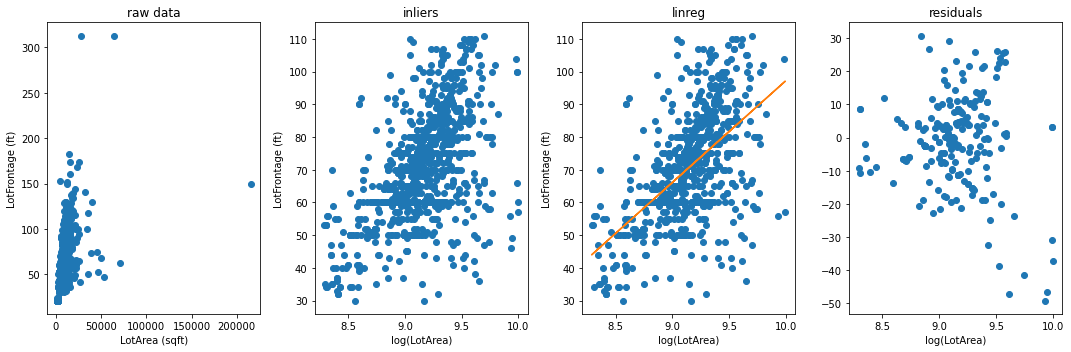

In [47]:
# consider filling 'LotFrontage' with extrapolated value

# function to get indexes of non-outliers
def inlieridx(dfcol):
    dataidx = dfcol.notna()
    data = dfcol[dataidx]
    med = np.median(data)
    p25, p75 = np.percentile(data, [25,75])
    iqr = p75 - p25
    upper = p75 + (1.5*iqr)
    lower = p25 - (1.5*iqr)
    index = data.index[(data >= lower) & (data <= upper)].tolist()
    return index

# indexes of non-outliers of area and frontage
areaidx = inlieridx(np.log(traindf['LotArea'].copy()))
frontidx = inlieridx(traindf['LotFrontage'])
idxx = list(set(areaidx) & set(frontidx))
#print(len(idxx))

# non-outlier rows of lotarea and lotfrontage
lotarea = np.log(traindf.loc[idxx, ['LotArea']].copy())
lotfront = traindf.loc[idxx, ['LotFrontage']].copy()
# train test split
tx, vx, ty, vy = train_test_split(lotarea, lotfront, train_size=0.8, test_size=0.2)
# fit linear model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

lfmodel = LinearRegression()
'''
lfmodel = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('lr', LinearRegression(fit_intercept=False))
])
'''


# data still heteroscedastic
#tx1d = np.exp(tx.values.reshape(-1))
#lfmodel.fit(tx.values.reshape(-1,1), ty.values.reshape(-1), sample_weight=1/(tx1d**2))
lfmodel.fit(tx.values.reshape(-1,1), ty.values.reshape(-1))
# store intercept and coefficient
lfintercept = lfmodel.intercept_
lfcoef = lfmodel.coef_

# plots
fig, axs = plt.subplots(1,4, figsize=(15,5))
# raw data
axs[0].plot(traindf['LotArea'],traindf['LotFrontage'], 'o')
axs[0].set_title('raw data')
axs[0].set_xlabel('LotArea (sqft)')
axs[0].set_ylabel('LotFrontage (ft)')
# inliers
axs[1].plot(lotarea, lotfront, 'o')
axs[1].set_title('inliers')
axs[1].set_xlabel('log(LotArea)')
axs[1].set_ylabel('LotFrontage (ft)')
# weighted linear regression
axs[2].plot(tx, ty, 'o')
axs[2].set_title('linreg')
axs[2].set_xlabel('log(LotArea)')
axs[2].set_ylabel('LotFrontage (ft)')
axs[2].plot(tx, (lfcoef * tx) + lfintercept)
# residuals
predfront = lfmodel.predict(vx)
axs[3].plot(vx, vy-predfront.reshape(-1,1), 'o')
axs[3].set_title('residuals')
axs[3].set_xlabel('log(LotArea)')

fig.tight_layout()

In [48]:
def fitlotfront(df):
    # indexes of non-outliers of log(area) and frontage
    areaidx = inlieridx(np.log(df['LotArea'].copy()))
    frontidx = inlieridx(df['LotFrontage'])
    idxx = list(set(areaidx) & set(frontidx))
    #print(len(idxx))

    # non-outlier rows of lotarea and lotfrontage
    lotarea = np.log(df.loc[idxx, ['LotArea']].copy())
    lotfront = df.loc[idxx, ['LotFrontage']].copy()
    #print(lotarea.isna().sum())
    #print(lotfront.isna().sum())
    
    # data still heteroscedastic
    lfmodel = LinearRegression()
    lfmodel.fit(lotarea.values.reshape(-1,1), lotfront.values.reshape(-1))

    
    # store intercept and coefficient
    lfintercept = lfmodel.intercept_
    lfcoef = lfmodel.coef_
    
    return lfintercept, lfcoef
    
def filllotfront(df, lfintercept, lfcoef):    
    # fill LotFrontage na with predicted val
    lotfrontna = df['LotFrontage'].isna()
    df.loc[lotfrontna, 'LotFrontage'] = lfcoef*(np.log(df.loc[lotfrontna, 'LotArea'].copy())) + lfintercept
    
    return df


In [49]:
# test filling lotfrontage na with lotfrontage median by neighborhood
def lfstats(df):
    #from scipy.stats import median
    medianlf = df.groupby('Neighborhood')['LotFrontage'].median()
    return medianlf

def filllf(df, medianlf):
    # fill LotFrontage na with neighborhood median
    lfna = df['LotFrontage'].isna()
    
    for row in df[lfna].index:
        nhood = df.loc[row, 'Neighborhood']
        df.loc[row, 'LotFrontage'] = medianlf[nhood]
    return df
        
medianlf = traindf.groupby('Neighborhood')['LotFrontage'].median()
print(medianlf)

Neighborhood
Blmngtn    43.0
Blueste    24.0
BrDale     21.0
BrkSide    52.0
ClearCr    80.0
CollgCr    70.0
Crawfor    74.0
Edwards    65.5
Gilbert    65.0
IDOTRR     60.0
MeadowV    21.0
Mitchel    73.0
NAmes      73.0
NPkVill    24.0
NWAmes     80.0
NoRidge    91.0
NridgHt    88.5
OldTown    60.0
SWISU      60.0
Sawyer     71.0
SawyerW    66.5
Somerst    73.5
StoneBr    61.5
Timber     85.0
Veenker    68.0
Name: LotFrontage, dtype: float64


In [50]:
# impute missing values

#def impute(df, lfintercept=None, lfcoef=None, modemvtype=None, meanmvarea=None, mode=None):
def impute(df, medianlf=None, modemvtype=None, meanmvarea=None, mode=None):
    
    if mode=='fit':
        # get stats
        lfintercept,lfcoef = fitlotfront(df)
        modemvtype, meanmvarea = mvstats(df)
        medianlf = lfstats(df)
    else:
        # fill LotFrontage 
        #df = filllotfront(df,lfintercept,lfcoef)
        df = filllf(df, medianlf)
        # fill MasVnr
        df = fillmasvnr(df, modemvtype, meanmvarea)
        
    # fill all other na with 0 or None
    for col in df.select_dtypes('number'):
        df[col] = df[col].fillna(0)
    for col in df.select_dtypes('category'):
        df[col] = df[col].fillna('None')
    
    if mode=='fit':
        #return df, lfintercept, lfcoef, modemvtype, meanmvarea
        return df, medianlf, modemvtype, meanmvarea
    else:
        return df

#print(traindf.select_dtypes('category'))
#print(traindf[nominal].isna().sum())
#print([traindf[x].cat.categories for x in ordinal])

In [51]:
# encode categorical data
def encodecat(df, xval=pd.DataFrame(), orderedlev=orderedlev, nominal=nominal, numerical=numerical):
    
    if xval.empty:
        X = df.copy()
    else:
        lenx = len(df)
        X = pd.concat([df.copy(),xval.copy()]).reset_index(drop=True)
    
    #X = df.copy()
    
    # ordinal
    # list of columns to ordinal encode
    ordcol = [key for key, _ in orderedlev.items()]
    # list of ordered levels for each columns
    levels = [value for _, value in orderedlev.items()]

    ordenc = OrdinalEncoder(categories=levels)
    Xord = pd.DataFrame(ordenc.fit_transform(X[ordcol]))
    Xord.columns = X[ordcol].columns
    #print(Xord.head())

    # nominal 
    nomenc = OneHotEncoder(handle_unknown='ignore', sparse=False)
    Xnom = pd.DataFrame(nomenc.fit_transform(X[nominal]))
    Xnom.columns = nomenc.get_feature_names_out(X[nominal].columns)
    #print(Xnom.head())
    
    Xencoded = X[numerical].join([Xord,Xnom])
    
    if xval.empty:
        return Xencoded
    else:
        Xenc = Xencoded.loc[0:lenx-1,:].copy()
        xvalenc = Xencoded.loc[lenx::,:].reset_index(drop=True).copy()
        
        return Xenc, xvalenc
    

### Baseline model

score for each fold: [0.12312856368806768, 0.10364093940838914, 0.11740033348638684, 0.16874338335429842, 0.14870061678138097, 0.11235400487203948, 0.12575037307765388, 0.10503317328503159, 0.21649618597244982, 0.12709250168076805]
Baseline RMSE:0.1348340075606466


Text(0.5, 0, 'log(SalePrice)')

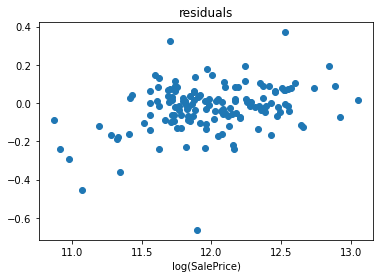

In [52]:
# evaluate baseline 
'''Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the 
predicted value and the logarithm of the observed sales price. (Taking logs means that errors 
in predicting expensive houses and cheap houses will affect the result equally.)'''

def scoreit(X, y, model):
    logy = np.log(y)
    ypred = cross_val_predict(model, X, logy, cv=10, method='predict')
    plt.plot(logy, logy-ypred, 'o')

    plt.xlabel('log(SalePrice)')
    plt.ylabel('log(SalePrice) - predicted log(price)')
    
    score = cross_val_score(model, X, logy, cv=10, scoring='neg_mean_squared_error')
    score = -1 * score.mean() # negative 1 makes lower score better
    score = np.sqrt(score) 
    return score


# baseline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler

traindf, testdf = load()
Xin = traindf.copy()
score=[]

kf = KFold(n_splits=10)
for trainidx, testidx in kf.split(Xin):
    X = Xin.loc[trainidx,:].copy() 
    y = X.pop('SalePrice')
    
    xval = Xin.loc[testidx,:].copy()
    yval = xval.pop('SalePrice')
    
    X = preprocess(X)
    X, medianlf, modemvtype, meanmvarea = impute(X,mode='fit')
    
    xval = preprocess(xval)
    xval = impute(xval,medianlf, modemvtype, meanmvarea)
    
    X, xval = encodecat(X, xval)
    
    # pipeline to standardize data and implement model
    numcol=numerical
    ct = ColumnTransformer([
        ('scaler', StandardScaler(), numcol),
    ], remainder='passthrough')

    ridgepipe = Pipeline([
        ('ct', ct),
        ('model', Ridge())
    ])

    ridgepipe.fit(X,np.log(y))
    ypred = ridgepipe.predict(xval)
    
    s = mean_squared_error(np.log(yval), ypred, squared=False) # squared=False gives RMSE
    score.append(s)
    
print(f'score for each fold: {score}')
print(f'Baseline RMSE:{np.mean(score)}')

plt.plot(np.log(yval),np.log(yval)-ypred, 'o')
plt.title('residuals')
plt.xlabel('log(SalePrice)')

### Feature selection and engineering

In [53]:
# feature selection
from sklearn.feature_selection import mutual_info_regression

def getmi(df,target):
    Xmi = df.copy()
    
    # select cat columns
    discrete = [col for col in (Xmi.dtypes=='category')]
    discretecol = Xmi.columns[discrete]
    # ordinal encode cat columns
    encoder = OrdinalEncoder()
    Xord = pd.DataFrame(encoder.fit_transform(Xmi[discretecol]))
    Xord.columns = discretecol
    # join ordinal encoded cols to numerical cols
    Xmi = Xmi[numerical].join(Xord)
    
    # mutual info
    d = [num for num in range(len(numerical)+1,len(Xmi.columns))]
    mi = mutual_info_regression(Xmi, target, discrete_features=np.array(d), random_state=123)
    
    miscores = pd.Series(mi,index=Xmi.columns).sort_values(ascending=False)
    
    return miscores
    
X = traindf.copy()
X = dropoutlier(X)
X = preprocess(X)
X, medianlf, modemvtype, meanmvarea = impute(X,mode='fit')
y = X.pop('SalePrice')

# get mutual information scores and print
miscores = getmi(X,y)
for i in range(len(miscores)):
    print(f'{miscores.index[i]}: {miscores[i]}')

OverallQual: 0.5794965641417034
Neighborhood: 0.5242035260533862
GrLivArea: 0.4780176122627622
GarageArea: 0.36721318499385935
TotalBsmtSF: 0.36600227457956125
YearBuilt: 0.36354170172011413
GarageCars: 0.35437710413047707
KitchenQual: 0.32928573985840925
ExterQual: 0.32704173122021785
BsmtQual: 0.32365531317567675
1stFlrSF: 0.30487986206268713
MSSubClass: 0.28364165964543897
FullBath: 0.270686275817128
GarageFinish: 0.263444865773925
GarageYrBlt: 0.25887733811664004
YearRemodAdd: 0.2554194463140185
TotRmsAbvGrd: 0.2163414922248541
FireplaceQu: 0.21188133493243622
GarageType: 0.20832968079120473
LotFrontage: 0.20665787913445266
Foundation: 0.19881858911982442
2ndFlrSF: 0.1960739620703258
Fireplaces: 0.168936171497009
Exterior2nd: 0.1679714520462614
HeatingQC: 0.16665979448666213
LotArea: 0.1606100050717072
BsmtFinType1: 0.15272149378229605
BsmtFinSF1: 0.1493456423442021
Exterior1st: 0.14383734154361916
OpenPorchSF: 0.142889691061586
MSZoning: 0.12312609984231537
BsmtUnfSF: 0.1189397142

In [54]:
# drop uninformative feat
def mifeat(df, miscores):
    # features to drop
    uninformative = miscores[miscores==0].index
    dropcol=[]
    for col in df.columns:
        for item in uninformative:
            if col.startswith(item):
                dropcol.append(col)
    #print(dropcol)
    df.drop(dropcol, axis=1, inplace=True)
    return df

In [55]:
# create features
def addfeat(df):
    Xadd = pd.DataFrame()
    Xadd['IndoorSpace'] = df.loc[:, ['TotalBsmtSF', 'GrLivArea']].sum(axis=1)
    Xadd['OutdoorSpace'] = df.loc[:,['OpenPorchSF', '3SsnPorch', 'PoolArea', 'WoodDeckSF', 'EnclosedPorch', 'ScreenPorch']].sum(axis=1)
    Xadd['HouseLotRatio'] = df['1stFlrSF'] / df['LotArea'] # indicator of yard size
    
    Xadd['TotBath'] = df.loc[:, ['FullBath','BsmtFullBath']].sum(axis=1) + 0.5*df.loc[:, ['HalfBath','BsmtHalfBath']].sum(axis=1)
    #Xadd['HouseBathRatio'] = (df.loc[:, ['FullBath', 'HalfBath']].sum(axis=1)) / insidesf
    Xadd['HousexLot'] = df['LotArea'] * Xadd['IndoorSpace'] # house and lot size
    Xadd['OverallQualCond'] = df['OverallQual'] * df['OverallCond']
    Xadd['ExterQualCond'] = df['ExterQual'] * df['ExterCond']
    
    # group house size and neighborhood
    neighborhoodcol = [col for col in df.columns if col.startswith('Neighborhood')]
    NeighborhoodSF = df[neighborhoodcol].multiply(Xadd['IndoorSpace'], axis=0)
    NeighborhoodSF.columns = ['SF' + col for col in neighborhoodcol]
    Xadd = Xadd.join(NeighborhoodSF)
    
    addnumcol = ['IndoorSpace','OutdoorSpace','TotBath','HouseLotRatio','HousexLot','OverallQualCond','ExterQualCond']
    
    #print(Xadd.head())
    return Xadd, addnumcol

In [56]:
# KFold score with added features, after dropping uninformative features, outliers

Xin = traindf.copy()
score=[]

kf = KFold(n_splits=10)
for trainidx, testidx in kf.split(Xin):
    # training set
    X = Xin.loc[trainidx,:].copy().reset_index(drop=True)
    X = dropoutlier(X)
    y = X.pop('SalePrice')
    # validation set
    xval = Xin.loc[testidx,:].copy().reset_index(drop=True)
    yval = xval.pop('SalePrice')
    
    X = preprocess(X)
    X, medianlf, modemvtype, meanmvarea = impute(X,mode='fit')
    
    xval = preprocess(xval)
    xval = impute(xval,medianlf, modemvtype, meanmvarea)
    
    # get mutual info scores
    miscores = getmi(X,y)
    # encode categorical features
    X, xval = encodecat(X, xval)
    
    # join
    lenx = len(X)
    Xall = pd.concat([X.copy(),xval.copy()]).reset_index(drop=True)
        
    # add features
    Xadd, addnumcol = addfeat(Xall)
    Xall = Xall.join(Xadd)
    # drop features
    Xall = mifeat(Xall, miscores)
    
    # re-split
    X = Xall.loc[0:lenx-1,:].copy()
    xval = Xall.loc[lenx::,:].reset_index(drop=True).copy()

    
    # pipeline to standardize data and implement model
    numcol = [col for col in numerical if col in X.columns] + addnumcol
    ct = ColumnTransformer([
        ('scaler', StandardScaler(), numcol),
    ], remainder='passthrough')

    ridgepipe = Pipeline([
        ('ct', ct),
        ('model', Ridge())
    ])

    ridgepipe.fit(X,np.log(y))
    ypred = ridgepipe.predict(xval)
    
    
    s = mean_squared_error(np.log(yval), ypred, squared=False) # squared=False gives RMSE
    score.append(s)
    
print(score)
print(np.mean(score))


[0.11377859043351175, 0.09489906341283144, 0.10473950369143571, 0.17904274945212764, 0.1397507378835102, 0.0986373481890558, 0.1104555913191655, 0.09561428011398765, 0.18159336533332818, 0.12239936693574481]
0.12409105967646987


array([[<AxesSubplot:title={'center':'LotFrontage'}>,
        <AxesSubplot:title={'center':'LotArea'}>,
        <AxesSubplot:title={'center':'YearBuilt'}>,
        <AxesSubplot:title={'center':'YearRemodAdd'}>,
        <AxesSubplot:title={'center':'MasVnrArea'}>,
        <AxesSubplot:title={'center':'BsmtFinSF1'}>],
       [<AxesSubplot:title={'center':'BsmtFinSF2'}>,
        <AxesSubplot:title={'center':'BsmtUnfSF'}>,
        <AxesSubplot:title={'center':'TotalBsmtSF'}>,
        <AxesSubplot:title={'center':'1stFlrSF'}>,
        <AxesSubplot:title={'center':'2ndFlrSF'}>,
        <AxesSubplot:title={'center':'GrLivArea'}>],
       [<AxesSubplot:title={'center':'BsmtFullBath'}>,
        <AxesSubplot:title={'center':'BsmtHalfBath'}>,
        <AxesSubplot:title={'center':'FullBath'}>,
        <AxesSubplot:title={'center':'HalfBath'}>,
        <AxesSubplot:title={'center':'BedroomAbvGr'}>,
        <AxesSubplot:title={'center':'KitchenAbvGr'}>],
       [<AxesSubplot:title={'center':'TotRmsA

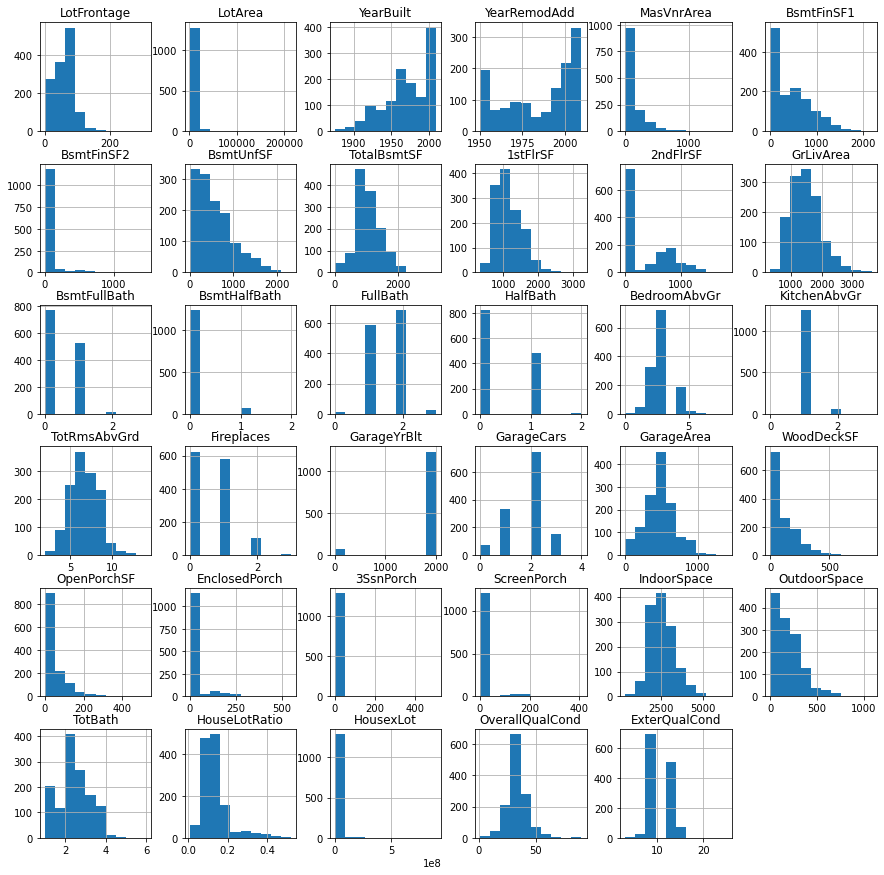

In [57]:
# look at distribution of numerical features
X[numcol].hist(figsize=(15,15))

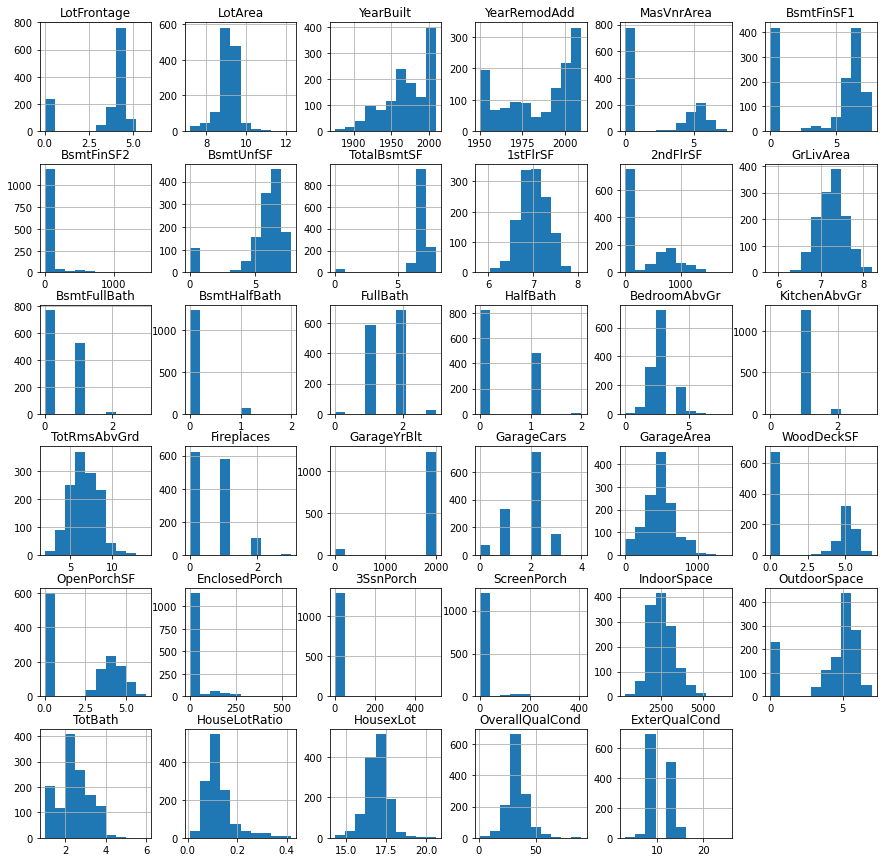

In [58]:
# take log of skewed columns
skewcol = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtUnfSF','TotalBsmtSF','1stFlrSF',
           'GrLivArea','WoodDeckSF','OpenPorchSF','OutdoorSpace','HouseLotRatio','HousexLot']
for item in skewcol: 
    X[item] = np.log1p(X[item])
    
X[numcol].hist(figsize=(15,15))

def skew(df):
    X = df.copy()
    skewcol = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtUnfSF','TotalBsmtSF','1stFlrSF',
           'GrLivArea','WoodDeckSF','OpenPorchSF','OutdoorSpace','HouseLotRatio','HousexLot']
    for item in skewcol: 
        X[item] = np.log1p(X[item])
    return X
    

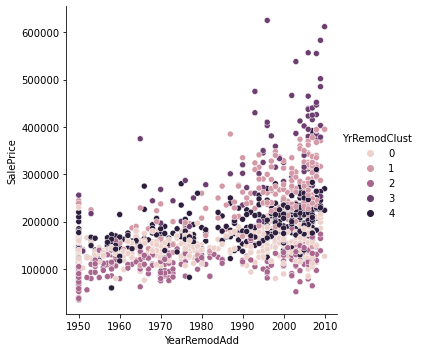

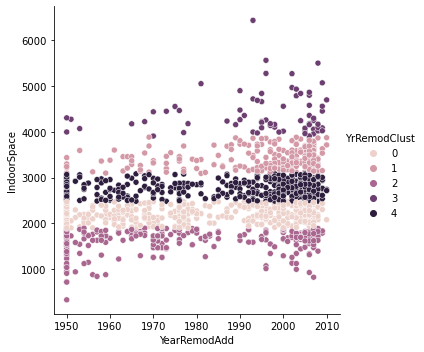

In [59]:
# clustering for feature engineering
from sklearn.cluster import KMeans

def clust(df, xval):
    X = df.copy()
    val = xval.copy()
    
    kmeans = KMeans(n_clusters=5, random_state=123)
    X['YrRemodClust'] = kmeans.fit_predict(X[['YearRemodAdd','IndoorSpace']])
    val['YrRemodClust'] = kmeans.predict(val[['YearRemodAdd','IndoorSpace']])
    return X, val

X = traindf.copy()
X = dropoutlier(X).reset_index(drop=True)
y = X.pop('SalePrice')

X['IndoorSpace'] = X.loc[:, ['TotalBsmtSF', 'GrLivArea']].sum(axis=1)
kmeans = KMeans(n_clusters=5, random_state=123)
X['YrRemodClust'] = kmeans.fit_predict(X[['YearRemodAdd','IndoorSpace']])
sns.relplot(x=X['YearRemodAdd'], y=y, hue=X['YrRemodClust'])
sns.relplot(x=X['YearRemodAdd'], y=X['IndoorSpace'], hue=X['YrRemodClust'])
    


In [60]:
def removecols(df):
    X = df.copy()
    # only keep normal salecondition since interested in normal sales
    removecol = [col for col in X.columns if col.startswith('SaleCondition')]
    removecol.remove('SaleCondition_Normal')
    
    # alley mostly none values, not big selling point 
    alleycol = [col for col in X.columns if col.startswith('Alley')]

    # only keep 'good wood' fence column
    fencecol = [col for col in X.columns if col.startswith('Fence')]
    fencecol.remove('Fence_GdWo')
    
    removecol = removecol + alleycol + fencecol
    #print(removecol)
    X = X.drop(removecol, axis=1)
    return X

In [61]:
# KFold score 

Xin = traindf.copy()
score=[]

kf = KFold(n_splits=10)
for trainidx, testidx in kf.split(Xin):
    # training set
    X = Xin.loc[trainidx,:].copy().reset_index(drop=True)
    X = dropoutlier(X)
    y = X.pop('SalePrice')
    # validation set
    xval = Xin.loc[testidx,:].copy().reset_index(drop=True)
    yval = xval.pop('SalePrice')
    
    X = preprocess(X)
    X, medianlf, modemvtype, meanmvarea = impute(X,mode='fit')
    
    xval = preprocess(xval)
    xval = impute(xval,medianlf, modemvtype, meanmvarea)
    
    # get mutual info scores
    miscores = getmi(X,y)
    # encode categorical features
    X, xval = encodecat(X, xval)
    
    # join
    lenx = len(X)
    Xall = pd.concat([X.copy(),xval.copy()]).reset_index(drop=True)
        
    # add features
    Xadd, addnumcol = addfeat(Xall)
    Xall = Xall.join(Xadd)
    # drop features
    Xall = mifeat(Xall, miscores)
    Xall = removecols(Xall)
    Xall = skew(Xall)
    
    # re-split
    X = Xall.loc[0:lenx-1,:].copy()
    xval = Xall.loc[lenx::,:].reset_index(drop=True).copy()
        
    # add clustered feature
    X, xval = clust(X,xval)
    
    # pipeline to standardize data and implement model
    numcol = [col for col in numerical if col in X.columns] + addnumcol
    ct = ColumnTransformer([
        ('oh', OneHotEncoder(handle_unknown='ignore', sparse=False), ['YrRemodClust']),
        ('scaler', StandardScaler(), numcol)
    ], remainder='passthrough')

    ridgepipe = Pipeline([
        ('ct', ct),
        ('model', Ridge())
    ])

    ridgepipe.fit(X,np.log(y))
    ypred = ridgepipe.predict(xval)
    
    
    s = mean_squared_error(np.log(yval), ypred, squared=False) # squared=False gives RMSE
    score.append(s)
    
print(score)
print(np.mean(score))


[0.11165804702304792, 0.09070336245485622, 0.1019895138078515, 0.16836793229067945, 0.13426040487833354, 0.09713758527027938, 0.11118237217444062, 0.09792605758032843, 0.18589384875269221, 0.12226335711306124]
0.12213824813455706


### Final model

score for each fold: [0.11230151263950627, 0.09007609953409856, 0.09913640526572229, 0.16837165842110657, 0.12960872959837583, 0.09695876837730734, 0.10999852103210837, 0.09674183207280503, 0.18877744472290883, 0.12123615822338053]
Final Model RMSE:0.12132071298873197


Text(0.5, 0, 'log(SalePrice)')

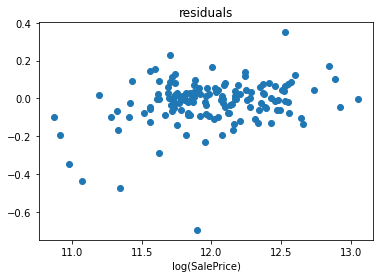

In [62]:
# KFold score with optimized alpha

Xin = traindf.copy()
score=[]

kf = KFold(n_splits=10)
for trainidx, testidx in kf.split(Xin):
    # training set
    X = Xin.loc[trainidx,:].copy().reset_index(drop=True)
    X = dropoutlier(X)
    y = X.pop('SalePrice')
    # validation set
    xval = Xin.loc[testidx,:].copy().reset_index(drop=True)
    yval = xval.pop('SalePrice')
    
    X = preprocess(X)
    X, medianlf, modemvtype, meanmvarea = impute(X,mode='fit')
    
    xval = preprocess(xval)
    xval = impute(xval,medianlf, modemvtype, meanmvarea)
    
    # get mutual info scores
    miscores = getmi(X,y)
    # encode categorical features
    X, xval = encodecat(X, xval)
    
    # join
    lenx = len(X)
    Xall = pd.concat([X.copy(),xval.copy()]).reset_index(drop=True)
        
    # add features
    Xadd, addnumcol = addfeat(Xall)
    Xall = Xall.join(Xadd)
    # drop features
    Xall = mifeat(Xall, miscores)
    Xall = removecols(Xall)
    Xall = skew(Xall)
    
    # re-split
    X = Xall.loc[0:lenx-1,:].copy()
    xval = Xall.loc[lenx::,:].reset_index(drop=True).copy()
        
    # add clustered feature
    X, xval = clust(X,xval)
    
    # pipeline to standardize data and implement model
    numcol = [col for col in numerical if col in X.columns] + addnumcol
    ct = ColumnTransformer([
        ('oh', OneHotEncoder(handle_unknown='ignore', sparse=False), ['YrRemodClust']),
        ('scaler', StandardScaler(), numcol)
    ], remainder='passthrough')

    ridgepipe = Pipeline([
        ('ct', ct),
        ('model', Ridge(alpha=4.5))
    ])

    ridgepipe.fit(X,np.log(y))
    ypred = ridgepipe.predict(xval)
    
    
    s = mean_squared_error(np.log(yval), ypred, squared=False) # squared=False gives RMSE
    score.append(s)

print(f'score for each fold: {score}')
print(f'Final Model RMSE:{np.mean(score)}')

plt.plot(np.log(yval),np.log(yval)-ypred, 'o')
plt.title('residuals')
plt.xlabel('log(SalePrice)')

### Predictions on test data

In [63]:
# generate predictions on test set
traindf, testdf = load()

X = traindf.copy()
X = dropoutlier(X).reset_index(drop=True)
y = X.pop('SalePrice')

xval = testdf.copy()
#yval = xval.pop('SalePrice')

X = preprocess(X)
X, medianlf, modemvtype, meanmvarea = impute(X,mode='fit')

xval = preprocess(xval)
xval = impute(xval,medianlf, modemvtype, meanmvarea)

# get mutual info scores
miscores = getmi(X,y)
# encode categorical features
X, xval = encodecat(X, xval)

# join
lenx = len(X)
Xall = pd.concat([X.copy(),xval.copy()]).reset_index(drop=True)

# add features
Xadd, addnumcol = addfeat(Xall)
Xall = Xall.join(Xadd)
# drop features
Xall = mifeat(Xall, miscores)
Xall = removecols(Xall)
Xall = skew(Xall)

# re-split
X = Xall.loc[0:lenx-1,:].copy()
xval = Xall.loc[lenx::,:].reset_index(drop=True).copy()

# add clustered feature
X, xval = clust(X,xval)

# pipeline to standardize data and implement model
numcol = [col for col in numerical if col in X.columns] + addnumcol
ct = ColumnTransformer([
    ('oh', OneHotEncoder(handle_unknown='ignore', sparse=False), ['YrRemodClust']),
    ('scaler', StandardScaler(), numcol)
], remainder='passthrough')

ridgepipe = Pipeline([
    ('ct', ct),
    ('model', Ridge(alpha=4.5))
])

# fit and predict    
ridgepipe.fit(X,np.log(y))
predictions = np.exp(ridgepipe.predict(xval))


output = pd.DataFrame({'Id': testdf.Id, 'SalePrice': predictions})
output.to_csv('my_submission.csv', index=False)

print('Final model scored RMSE 0.12498 on test set')


Final model scored RMSE 0.12498 on test set


In [64]:
print(output)

        Id      SalePrice
0     1461  122778.459410
1     1462  148573.419556
2     1463  182246.877396
3     1464  195522.846958
4     1465  195627.578162
...    ...            ...
1454  2915   83847.749994
1455  2916   78808.540464
1456  2917  164978.659563
1457  2918  121483.743199
1458  2919  219029.295079

[1459 rows x 2 columns]
